In [8]:

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.relu(train_x * (2 * math.pi)-2) + torch.randn(train_x.size()) * math.sqrt(0.004)

In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


In [11]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()


Iter 1/50 - Loss: 0.969   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.910   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.852   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.796   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.743   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.694   lengthscale: 0.477   noise: 0.474
Iter 7/50 - Loss: 0.647   lengthscale: 0.444   noise: 0.437
Iter 8/50 - Loss: 0.603   lengthscale: 0.415   noise: 0.402
Iter 9/50 - Loss: 0.560   lengthscale: 0.391   noise: 0.370
Iter 10/50 - Loss: 0.518   lengthscale: 0.370   noise: 0.340
Iter 11/50 - Loss: 0.477   lengthscale: 0.354   noise: 0.311
Iter 12/50 - Loss: 0.435   lengthscale: 0.341   noise: 0.285
Iter 13/50 - Loss: 0.393   lengthscale: 0.331   noise: 0.261
Iter 14/50 - Loss: 0.351   lengthscale: 0.323   noise: 0.238
Iter 15/50 - Loss: 0.309   lengthscale: 0.318   noise: 0.217
Iter 16/50 - Loss: 0.266   lengthscale: 0.316   noise: 0.198
Iter 17/50 - Loss: 0.223   length

In [12]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))


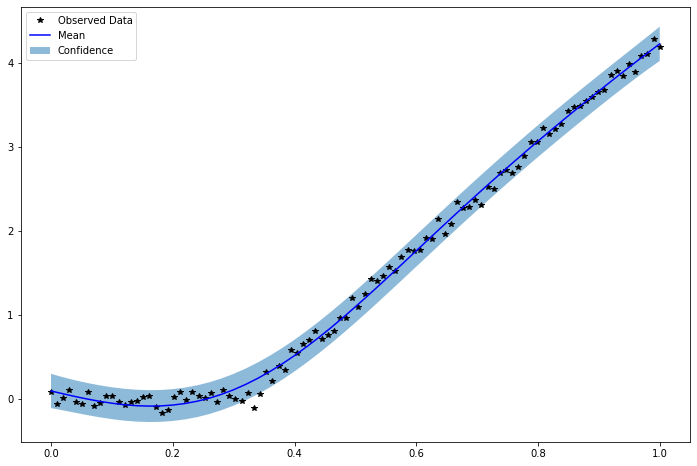

In [13]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])